In [79]:
import numpy as np
import mujoco
import mediapy as media

from vis_util import Joint, open_files
np_data = open_files("aist/keypoints3d/gHO_sBM_cAll_d19_mHO2_ch07.pkl")
f=200

(480, 17, 3)
(480, 17, 3)


In [80]:
xml = './low_cost_robot/scene.xml'
model = mujoco.MjModel.from_xml_path(xml)
data = mujoco.MjData(model)

model.vis.global_.offheight = 720
model.vis.global_.offwidth = 1080

renderer = mujoco.Renderer(model, height=720, width=1080)

In [81]:
camera = mujoco.MjvCamera()
mujoco.mjv_defaultFreeCamera(model, camera)
camera.distance = 0.6


In [82]:
ranges = [
    [np.pi/2, -np.pi/2],  # Column 1 range\n",
    # TODO 이거 너무 range가 적은 것 같은데?
    [np.pi/8, -np.pi/8],  # Column 2 range\n",
    # [np.pi/2, np.pi/4],  # Column 3 range\n",
    [np.pi/2, 0],  # Column 3 range\n",

    [np.pi/2, -np.pi/2],  # Column 4 range\n",
    [np.pi/2, -np.pi/2],  # Column 5 range\n",
]

def denormalize(idx, point):
    point = np.clip(point, 0, 1)
    if idx == 5:
        return 0
    return ranges[idx][0] * point + ranges[idx][1] * (1 - point)

initial point,after point

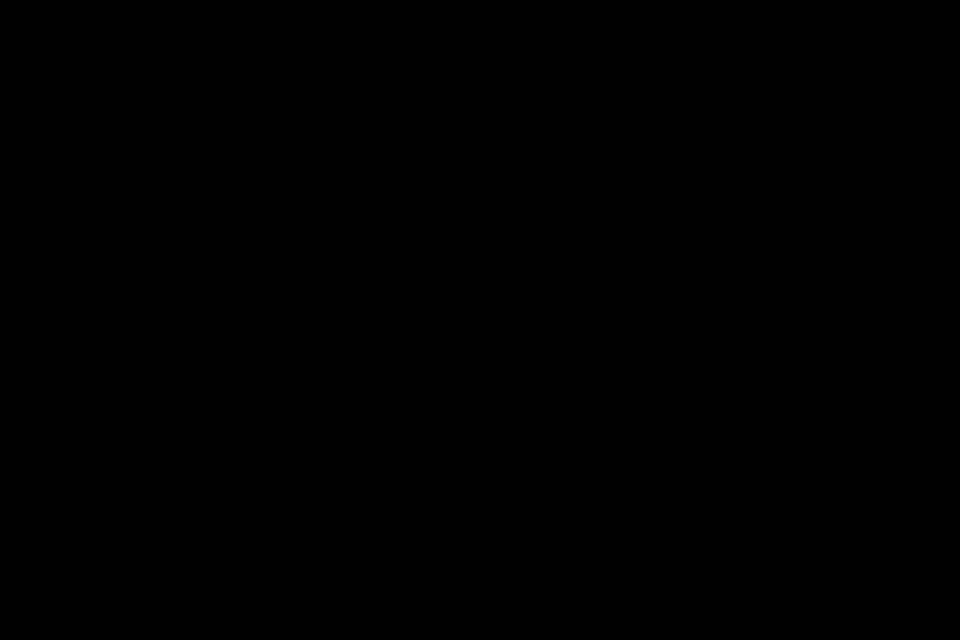
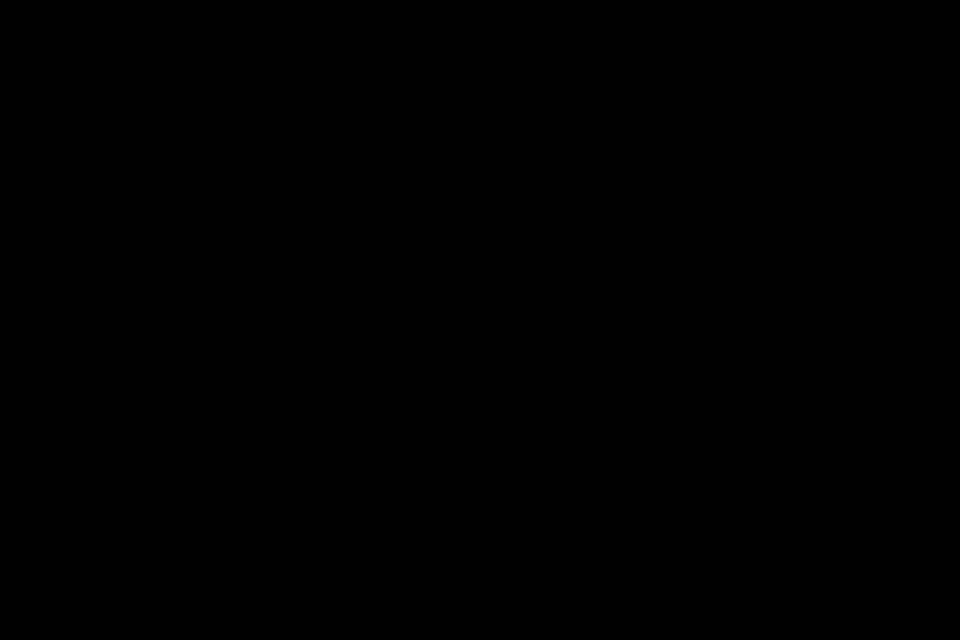

In [83]:
qinit = data.qpos.copy()
mujoco.mj_resetDataKeyframe(model, data, 1)
mujoco.mj_forward(model, data)
renderer.update_scene(data, camera)
init_plot = renderer.render()


# init_point = data.body(jname).xpos.copy()
normalized_qpos = [0.5, 0.5, 0.5, 1, 0, 0]
data.qpos = np.array([denormalize(idx, p) for idx, p in enumerate(normalized_qpos)])
qpos0 = data.qpos.copy()
mujoco.mj_forward(model, data)
renderer.update_scene(data, camera)
after_plot = renderer.render()

images = {
    "initial point": init_plot,
    "after point": after_plot,
}
media.show_images(images=images, height=640)

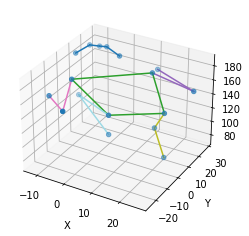

In [84]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colormaps
from vis_util import connections, connection_info, set_part_color

kpts_3d = np_data

# 특정 프레임 선택 (예: 첫 번째 프레임)
frame_kpts = kpts_3d[f]  # shape: (17, 3)

# x, y, z 좌표 분리
x = frame_kpts[:, 0]
y = frame_kpts[:, 1]
z = frame_kpts[:, 2]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 점 플롯
ax.scatter(x, y, z)

cmap = colormaps["tab20"].resampled(len(connection_info))
for i, (start, end) in enumerate(connections):
    xs = [x[start], x[end]]
    ys = [y[start], y[end]]
    zs = [z[start], z[end]]
    ax.plot(xs, ys, zs, c=cmap.colors[set_part_color((start, end))[0]])

# 축 라벨
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

In [85]:
head_n = head_norm_vec(np_data[f])
head_n

array([ 0.25874185, -0.75506392,  0.57076913])

In [86]:
torso_n = torso_norm_vec(np_data[f])
torso_n

array([ 0.96974379, -0.0414377 ,  0.24058242])

In [87]:
def unit_vec(vec:np.ndarray):
    assert vec.ndim == 1 and vec.shape[0] == 3, f"Invalid vector input: {vec}"
    vec /= np.linalg.norm(vec)
    return vec

def angle_interpolate(np_datas, weights=None):
    if weights is None:
        ds = np.array([unit_vec(d) for d in np_datas])
    else:
        assert np.abs(np.sum(weights) - 1) < 1e-8
        ds = np.array([unit_vec(d) * w for d, w in zip(np_datas, weights)])
    interp_vec = np.sum(ds, axis=0)
    interp_vec /= np.linalg.norm(interp_vec)
    return interp_vec


def euclid3d_to_polar1d(euc):
    r = np.linalg.norm([euc[0], euc[1]])
    theta = np.arctan2(euc[1]/r, euc[0]/r)
    return theta

In [88]:
def debug_cross(**kwargs):
    elems = []
    if kwargs.get("debug", False):
        for k,v in kwargs.items():
            if k != "debug":
                print(f"{k}: {v}")
                elems.append(v)
    return np.cross(elems[0], elems[1])

In [89]:
a = angle_interpolate(np_datas=[np.array([1.0, 0.0, 0.]), np.array([0., 0., 1.])], weights=[1/3, 2/3])
print(a)
print(np.array([np.sin(np.pi/6), 0, np.cos(np.pi/6)]))
# seems quite different, but ignore small error

[0.4472136  0.         0.89442719]
[0.5       0.        0.8660254]


In [90]:
def torso_norm_vec(np_data):
    assert np_data.ndim == 2, f"dimension of input np array is mismatched. {np_data.ndim} != 2"
    l_sholder, r_sholder, l_hip, r_hip = np_data[Joint.L_SHOLDER.value], np_data[Joint.R_SHOLDER.value], np_data[Joint.L_HIP.value], np_data[Joint.R_HIP.value]
    l_elbow, l_wrist = np_data[Joint.L_ELBOW.value], np_data[Joint.L_WRIST.value]
    r_elbow, r_wrist = np_data[Joint.R_ELBOW.value], np_data[Joint.R_WRIST.value]

    l_sholder_to_r_hip, r_sholder_to_l_hip = unit_vec(r_hip - l_sholder), unit_vec(l_hip - r_sholder)
    l_sholder_to_elbow, l_elbow_to_wrist = unit_vec(l_elbow - l_sholder), unit_vec(l_wrist - l_elbow)
    r_sholder_to_elbow, r_elbow_to_wrist = unit_vec(r_elbow - r_sholder), unit_vec(r_wrist - r_elbow)
    torso_n = debug_cross(r_sholder_to_l_hip=r_sholder_to_l_hip, l_sholder_to_r_hip=l_sholder_to_r_hip, debug=True) 
    l_arm_n = debug_cross(l_elbow_to_wrist=l_elbow_to_wrist, l_sholder_to_elbow=l_sholder_to_elbow, debug=True)
    r_arm_n = debug_cross(r_elbow_to_wrist=r_elbow_to_wrist, r_sholder_to_elbow=r_sholder_to_elbow, debug=True)
    torso_n = angle_interpolate([torso_n, l_arm_n, r_arm_n], weights=[2/4, 1/4, 1/4])
    return torso_n
torso_n = torso_norm_vec(np_data=np_data[f])

r_sholder_to_l_hip: [ 0.54914401  0.29991166 -0.78006016]
l_sholder_to_r_hip: [-0.1551677  -0.50860733 -0.84690115]
l_elbow_to_wrist: [-0.87642474  0.41783945  0.23935303]
l_sholder_to_elbow: [ 0.60215051  0.17954246 -0.77793269]
r_elbow_to_wrist: [-0.60410983  0.68487962 -0.40742019]
r_sholder_to_elbow: [ 0.22437383 -0.80281038 -0.55240553]


In [91]:
def head_norm_vec(np_data):
    assert np_data.ndim == 2, f"dimension of input np array is mismatched. {np_data.ndim} != 2"
    # l_eye, r_eye = np_data[Joint.L_EYE.value], np_data[Joint.R_EYE.value]
    l_ear, r_ear = np_data[Joint.L_EAR.value], np_data[Joint.R_EAR.value]
    l_sholder, r_sholder = np_data[Joint.L_SHOLDER.value], np_data[Joint.R_SHOLDER.value]
    neck = (l_sholder + r_sholder) / 2
    l_ear_to_r_ear = unit_vec(l_ear - r_ear)
    mid_ear = (l_ear + r_ear) / 2
    mid_ear_to_neck = unit_vec(neck - mid_ear)
    # print(f"mid_ear_to_neck: {mid_ear_to_neck}")
    # print(f"l_ear_to_r_ear: {l_ear_to_r_ear}")
    head_n = debug_cross(mid_ear_to_neck=mid_ear_to_neck, l_ear_to_r_ear=l_ear_to_r_ear, debug=True) 
    `return head_n
head_n = head_norm_vec(np_data[f])

SyntaxError: invalid syntax (2171137691.py, line 13)

In [92]:
def leg_hinge_norm_vec(np_data):
    def calc_one_leg(hip, knee, ankle):
        up, down = unit_vec(hip - knee), unit_vec(knee - ankle)
        n = np.cross(up, down)
        up_norm_vec = np.cross(n, up)
        down_norm_vec = np.cross(n, down)
        return up_norm_vec, down_norm_vec
    assert np_data.ndim == 2, f"dimension of input np array is mismatched. {np_data.ndim} != 2"
    l_hip, l_knee, l_ankle = np_data[Joint.L_HIP.value], np_data[Joint.L_KNEE.value], np_data[Joint.L_ANKLE.value]
    r_hip, r_knee, r_ankle = np_data[Joint.R_HIP.value], np_data[Joint.R_KNEE.value], np_data[Joint.R_ANKLE.value]
    l_up_n, l_down_n = calc_one_leg(l_hip, l_knee, l_ankle)
    r_up_n, r_down_n = calc_one_leg(r_hip, r_knee, r_ankle)
    return l_up_n, l_down_n, r_up_n, r_down_n
def leg_norm_vec(np_data):
    lleg_up_n, lleg_down_n, rleg_up_n, rleg_down_n = leg_hinge_norm_vec(np_data)
    leg_n = angle_interpolate([lleg_up_n, lleg_down_n, rleg_up_n, rleg_down_n])
    return leg_n
lleg_up_n, lleg_down_n, rleg_up_n, rleg_down_n = leg_hinge_norm_vec(np_data=np_data[f])

In [93]:
leg_n = angle_interpolate([lleg_up_n, lleg_down_n, rleg_up_n, rleg_down_n])
barrel_norm_vec = angle_interpolate([leg_n, torso_n])

In [94]:
def angle_between_vectors(u: np.ndarray, v: np.ndarray):
    u = u / np.linalg.norm(u)
    v = v / np.linalg.norm(v)
    dot_val = np.dot(u, v)
    # 수치 에러 방지용 clip
    dot_val = np.clip(dot_val, -1.0, 1.0)
    angle = np.arccos(dot_val)
    return angle

In [95]:
def signed_angle_between(u: np.ndarray, v: np.ndarray, n: np.ndarray):
    """
    u, v는 3D 벡터, n은 기준이 되는 노멀 벡터(예: 두 벡터가 속한 평면의 노멀).
    n은 단위벡터(normalized)여야 하며, u와 v도 일반적으로 단위벡터로 두는 것이 좋다.
    """
    # 단위벡터화
    u = u / np.linalg.norm(u)
    v = v / np.linalg.norm(v)
    n = n / np.linalg.norm(n)
    
    # 기본 각도 (0 ~ π)
    angle = np.arccos(np.clip(np.dot(u, v), -1.0, 1.0))
    # 외적을 통해 회전 방향 판단
    cross_uv = np.cross(u, v)
    # n과 cross_uv가 얼마나 정렬되어 있는지에 따라 부호 결정
    sign = np.sign(np.dot(n, cross_uv))
    
    # sign이 양수면 angle 유지, 음수면 angle에 음수 부호를 부여
    signed_angle = angle * sign
    return signed_angle


In [96]:
def signed_angle_between_vectors(u, v):
    angle = angle_between_vectors(u, v)
    if u[2] < v[2]:
        return -angle
    else:
        return angle

In [97]:
def joint1():
    xy_theta = euclid3d_to_polar1d(-barrel_norm_vec)
    return xy_theta
    normalized = xy_theta / np.pi / 2 + np.pi / 2
    joint1_theta = denormalize(idx=0, point=normalized)
    return joint1_theta, barrel_norm_vec

joint1()


-0.340473074594819

In [98]:
torso_n

array([-0.96974379,  0.0414377 , -0.24058242])

In [99]:
barrel_norm_vec

array([-0.93855798,  0.33250222, -0.0924727 ])

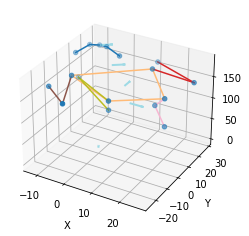

In [100]:
# -------------------------------------
# 기존 코드
# -------------------------------------
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colormaps
from vis_util import connections, connection_info, set_part_color, Joint

kpts_3d = np_data

frame_kpts = kpts_3d[f]  # shape: (17, 3)

# x, y, z 좌표 분리
x = frame_kpts[:, 0]
y = frame_kpts[:, 1]
z = frame_kpts[:, 2]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 점 플롯
ax.scatter(x, y, z)

cmap = colormaps["tab20"].resampled(len(connection_info) + 1)
for i, (start, end) in enumerate(connections):
    xs = [x[start], x[end]]
    ys = [y[start], y[end]]
    zs = [z[start], z[end]]
    ax.plot(xs, ys, zs, c=cmap.colors[set_part_color((start, end))[0]])

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# -------------------------------------
# 추가된 코드 (법선 벡터 시각화)
# -------------------------------------

# 예시로 barrel_n, leg_n, torso_n, head_n이 이미 계산되어 있다고 가정
# 예: barrel_n, leg_n, torso_n, head_n = ...
# 여기서는 dummy로 정의 (실제로는 사용자가 계산한 값을 넣어야 함)
barrel_n = np.array([0,0,1])    # 예: z축 방향
leg_n = np.array([1,0,0])       # 예: x축 방향
torso_n = np.array([0,1,0])     # 예: y축 방향
head_n = np.array([0.7,0.7,0])  # 예: 대략 대각선 방향

# 1. joint1(barrel_n): xy=(0,0)에서 z축과 이루는 각도를 표시
#   -> 시작점: 원점(0,0,0)

arrow_color = cmap.colors[-1]
origin = np.array([0,0,0])
ax.quiver(origin[0], origin[1], origin[2],
          barrel_n[0], barrel_n[1], barrel_n[2],
          length=5, color=arrow_color, linewidth=2, arrow_length_ratio=0.2)

# 2. joint2(leg_n): left_leg와 right_leg 좌표들의 평균 지점에서 법선 벡터 표시
leg_joints = [Joint.L_HIP.value, Joint.R_HIP.value, Joint.L_KNEE.value, Joint.R_KNEE.value, Joint.L_ANKLE.value, Joint.R_ANKLE.value]
leg_points = frame_kpts[leg_joints]
leg_center = np.mean(leg_points, axis=0)
ax.quiver(leg_center[0], leg_center[1], leg_center[2],
          leg_n[0], leg_n[1], leg_n[2],
          length=5, color=arrow_color, linewidth=2, arrow_length_ratio=0.2)

# 3. joint3(torso_n): L_SHOLDER, R_SHOLDER, L_HIP, R_HIP 중점에서 torso_n 표시
torso_joints = [Joint.L_SHOLDER.value, Joint.R_SHOLDER.value, Joint.L_HIP.value, Joint.R_HIP.value]
torso_points = frame_kpts[torso_joints]
torso_center = np.mean(torso_points, axis=0)
ax.quiver(torso_center[0], torso_center[1], torso_center[2],
          torso_n[0], torso_n[1], torso_n[2],
          length=5, color=arrow_color, linewidth=2, arrow_length_ratio=0.2)

# 4. joint4(head_n): torso의 중점과 nose point의 중점에서 head_n 표시
nose_point = frame_kpts[Joint.NOSE.value]
mid_torso_nose = (torso_center + nose_point) / 2
ax.quiver(mid_torso_nose[0], mid_torso_nose[1], mid_torso_nose[2],
          head_n[0], head_n[1], head_n[2],
          length=5, color=arrow_color, linewidth=2, arrow_length_ratio=0.2)

# 5. joint5(head_n): nose point에서 head_n 표시
ax.quiver(nose_point[0], nose_point[1], nose_point[2],
          head_n[0], head_n[1], head_n[2],
          length=5, color=arrow_color, linewidth=2, arrow_length_ratio=0.2)

plt.show()

In [103]:
def joints(lleg_down_n, rleg_down_n, lleg_up_n, rleg_up_n, torso_n, head_n):
    def joint1():
        leg_n = angle_interpolate([lleg_up_n, lleg_down_n, rleg_up_n, rleg_down_n])
        barrel_norm_vec = angle_interpolate([leg_n, torso_n, head_n])
        xy_theta = euclid3d_to_polar1d(-barrel_norm_vec)
        return xy_theta
        normalized = xy_theta / np.pi / 2 + np.pi / 2
        joint1_theta = denormalize(idx=0, point=normalized)
        return joint1_theta, barrel_norm_vec

    def joint2():
        leg_down_n = angle_interpolate([lleg_down_n, rleg_down_n])
        leg_down_n_proj_xy = np.array([*leg_down_n[:2], 0])
        theta = signed_angle_between_vectors(leg_down_n_proj_xy, leg_down_n)
        theta = np.clip(theta, ranges[1][1], ranges[1][0])
        return theta, leg_down_n
    joint2_theta, leg_down_n = joint2()

    def joint3():
        leg_up_n = angle_interpolate([lleg_up_n, rleg_up_n]) # get leg angle
        theta = signed_angle_between_vectors(leg_down_n, leg_up_n) # get angle between torso and leg
        theta = np.clip(theta, ranges[2][1], ranges[2][0]) # clipping 

        return theta

    def joint4():
        """
        get angle between torso and head
        """
        theta = signed_angle_between_vectors(torso_n, head_n) # get angle between torso and head
        theta = np.clip(theta, ranges[3][1], ranges[3][0]) # clipping 

        return theta
        
    def joint5():
        """
        get angle at which the head is rotated
        """
        theta = euclid3d_to_polar1d(-head_n)
        theta = np.clip(theta, ranges[4][1], ranges[4][0]) # clipping 

        return theta

    def joint6():
        theta = 0.0 # fixed to 0

        return theta

    # get angles of joint1-joint6
    joint1_theta = joint1()
    joint2_theta, _ = joint2()
    joint3_theta = joint3()
    joint4_theta = joint4()
    joint5_theta = joint5()
    joint6_theta = joint6()

    return joint1_theta, joint2_theta, joint3_theta, joint4_theta, joint5_theta, joint6_theta

In [104]:
# viz joint plot

joint_data_dict = {
    'joint1':[],
    'joint2':[],
    'joint3':[],
    'joint4':[],
    'joint5':[],
    # 'joint6':[],
    'lleg_up_n':[],
    'lleg_down_n':[],
    'rleg_up_n':[],
    'rleg_down_n':[],
    'head_n':[],
    'torso_n':[],
}

for frame in range(kpts_3d.shape[0]):
    frame_kpts = kpts_3d[frame]

    lleg_up_n, lleg_down_n, rleg_up_n, rleg_down_n = leg_hinge_norm_vec(np_data=frame_kpts)
    head_n = head_norm_vec(np_data=frame_kpts)
    torso_n = torso_norm_vec(np_data=frame_kpts)

    joint1_theta, \
    joint2_theta, \
    joint3_theta, \
    joint4_theta, \
    joint5_theta, \
    joint6_theta = joints(lleg_down_n, rleg_down_n, lleg_up_n, rleg_up_n, torso_n, head_n)

    joint_data_dict['joint1'].append(joint1_theta)
    joint_data_dict['joint2'].append(joint2_theta)
    joint_data_dict['joint3'].append(joint3_theta)
    joint_data_dict['joint4'].append(joint4_theta)
    joint_data_dict['joint5'].append(joint5_theta)

    joint_data_dict['lleg_up_n'].append(euclid3d_to_polar1d(-lleg_up_n))
    joint_data_dict['lleg_down_n'].append(euclid3d_to_polar1d(-lleg_down_n))
    joint_data_dict['rleg_up_n'].append(euclid3d_to_polar1d(-rleg_up_n))
    joint_data_dict['rleg_down_n'].append(euclid3d_to_polar1d(-rleg_down_n))
    joint_data_dict['head_n'].append(euclid3d_to_polar1d(-head_n))
    joint_data_dict['torso_n'].append(euclid3d_to_polar1d(-torso_n))

r_sholder_to_l_hip: [ 0.66875221  0.16862169 -0.72411132]
l_sholder_to_r_hip: [-0.2313008  -0.15059789 -0.96115567]
l_elbow_to_wrist: [ 0.97928488 -0.15475458  0.13058384]
l_sholder_to_elbow: [ 0.9963971  -0.07863679 -0.03176578]
r_elbow_to_wrist: [ 0.09966137  0.90525082 -0.41302368]
r_sholder_to_elbow: [-0.16157432  0.11593406 -0.98002706]
r_sholder_to_l_hip: [ 0.67194375  0.16865999 -0.72114174]
l_sholder_to_r_hip: [-0.24768976 -0.12278637 -0.96102721]
l_elbow_to_wrist: [ 0.98326244 -0.09944043  0.15266488]
l_sholder_to_elbow: [ 0.99729077 -0.07338833  0.00502659]
r_elbow_to_wrist: [ 0.05350656  0.87587088 -0.47956986]
r_sholder_to_elbow: [-0.15088007  0.17165281 -0.97353506]
r_sholder_to_l_hip: [ 0.67239604  0.15919369 -0.72286993]
l_sholder_to_r_hip: [-0.25645239 -0.09774348 -0.96160199]
l_elbow_to_wrist: [ 0.98243171 -0.01676142  0.18586821]
l_sholder_to_elbow: [ 0.9969291  -0.06468111  0.04414439]
r_elbow_to_wrist: [-0.0276093   0.80200882 -0.59667376]
r_sholder_to_elbow: [-0.13

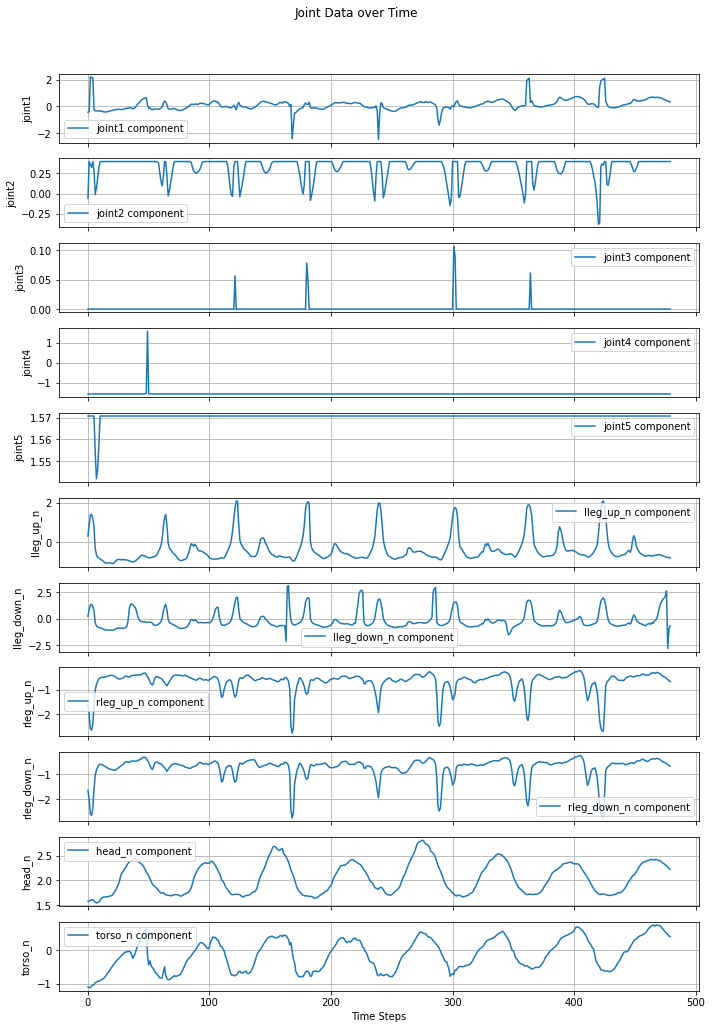

In [105]:
import matplotlib.pyplot as plt
import numpy as np

# 각 키에 대한 플롯 생성
fig, axes = plt.subplots(len(joint_data_dict), 1, figsize=(10, 15), sharex=True)
fig.suptitle('Joint Data over Time')

for ax, (key, d) in zip(axes, joint_data_dict.items()):
    time_steps = np.arange(len(d))  # 시간축 (예: 0, 1, 2, ..., n)
    # for i in range(d.shape[1]):
    ax.plot(time_steps, d, label=f'{key} component')# {i+1}')
    ax.set_ylabel(key)
    ax.legend()
    ax.grid(True)

axes[-1].set_xlabel('Time Steps')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()